# Tagging and Extraction Using OpenAI functions

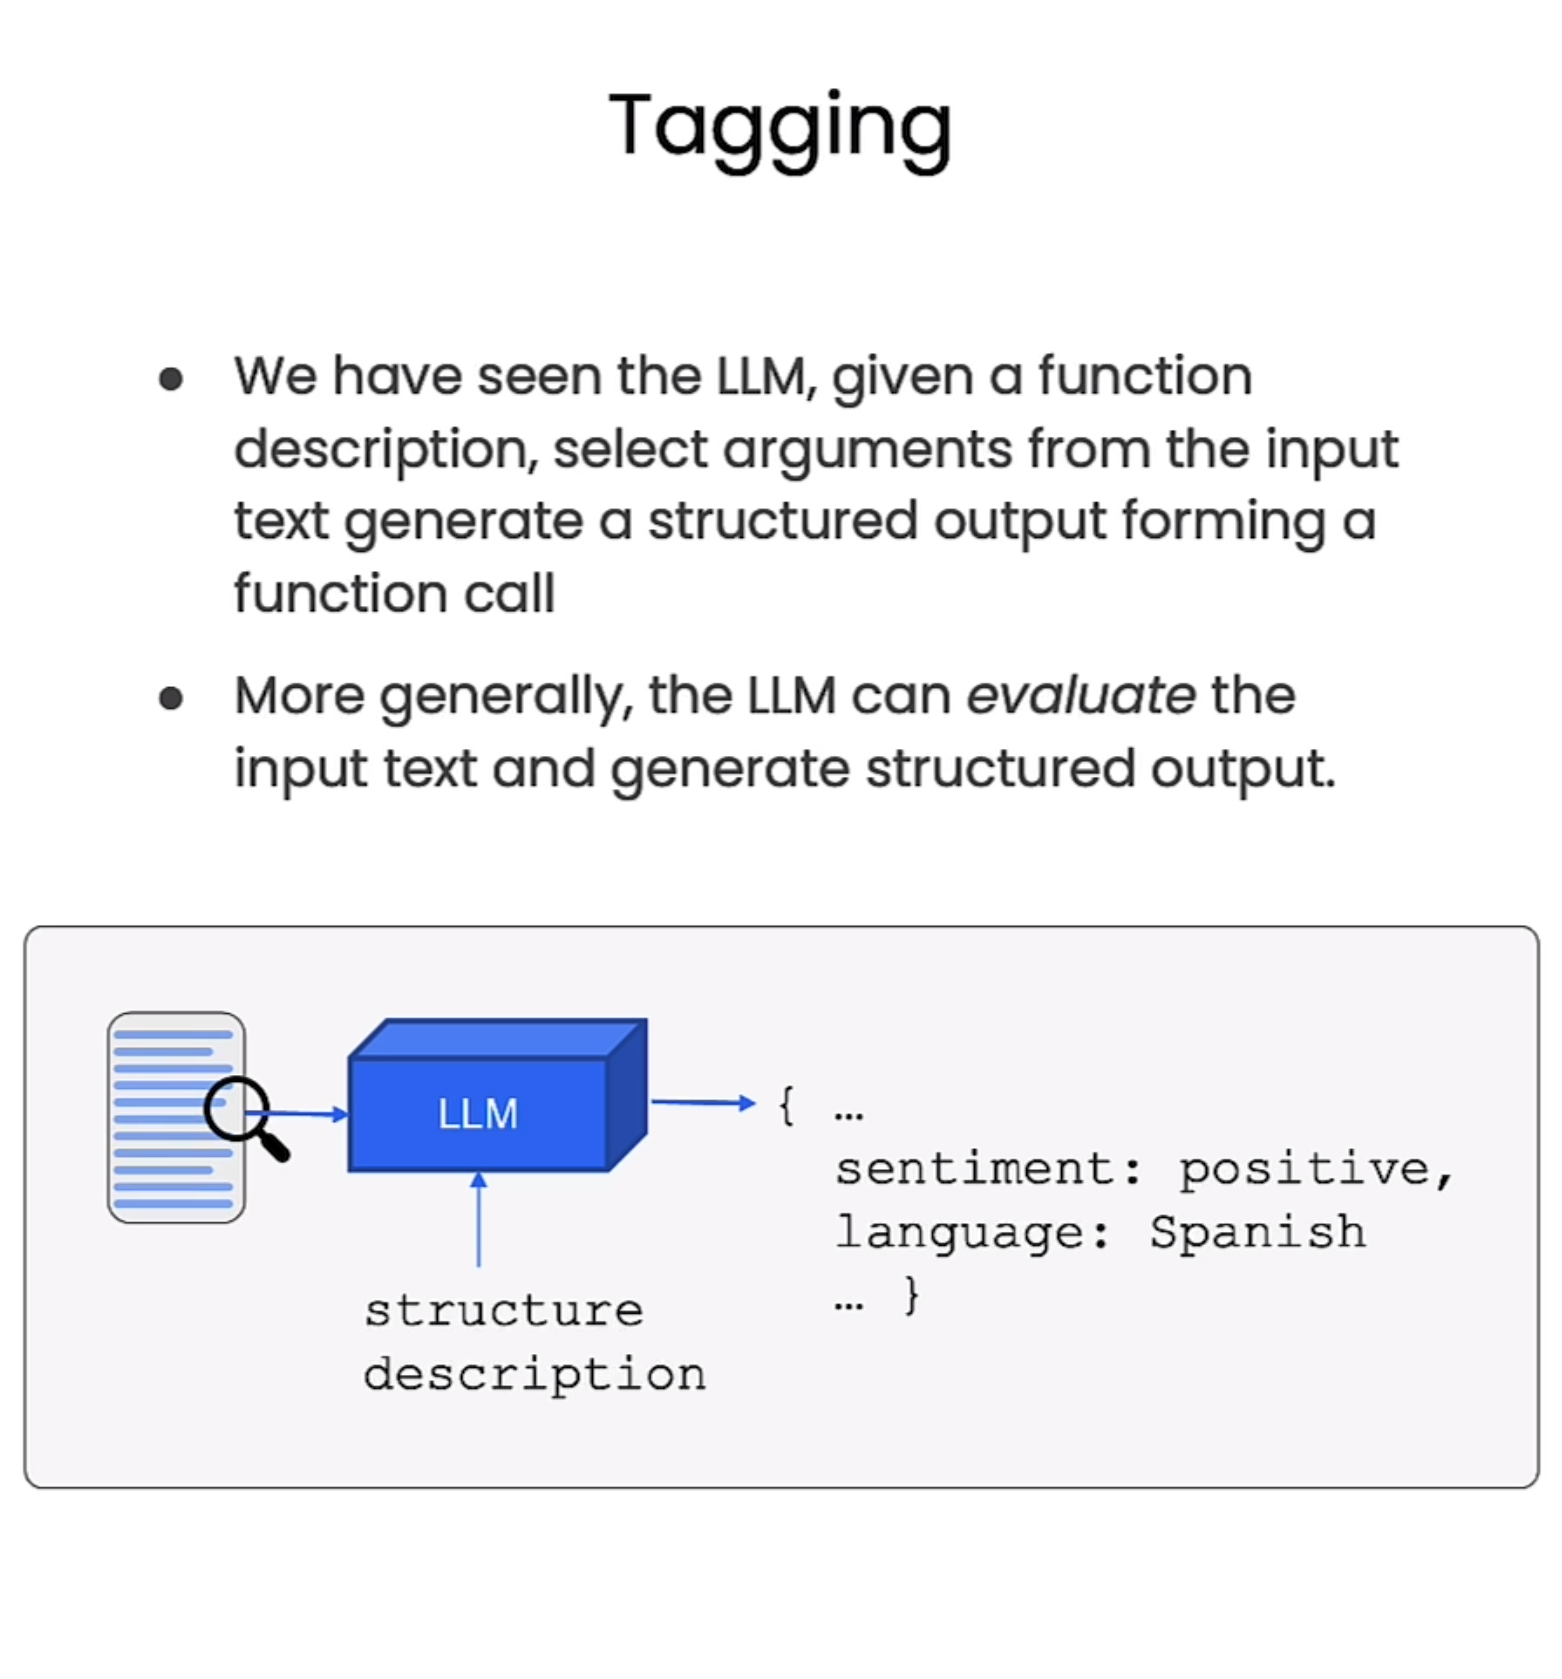

---

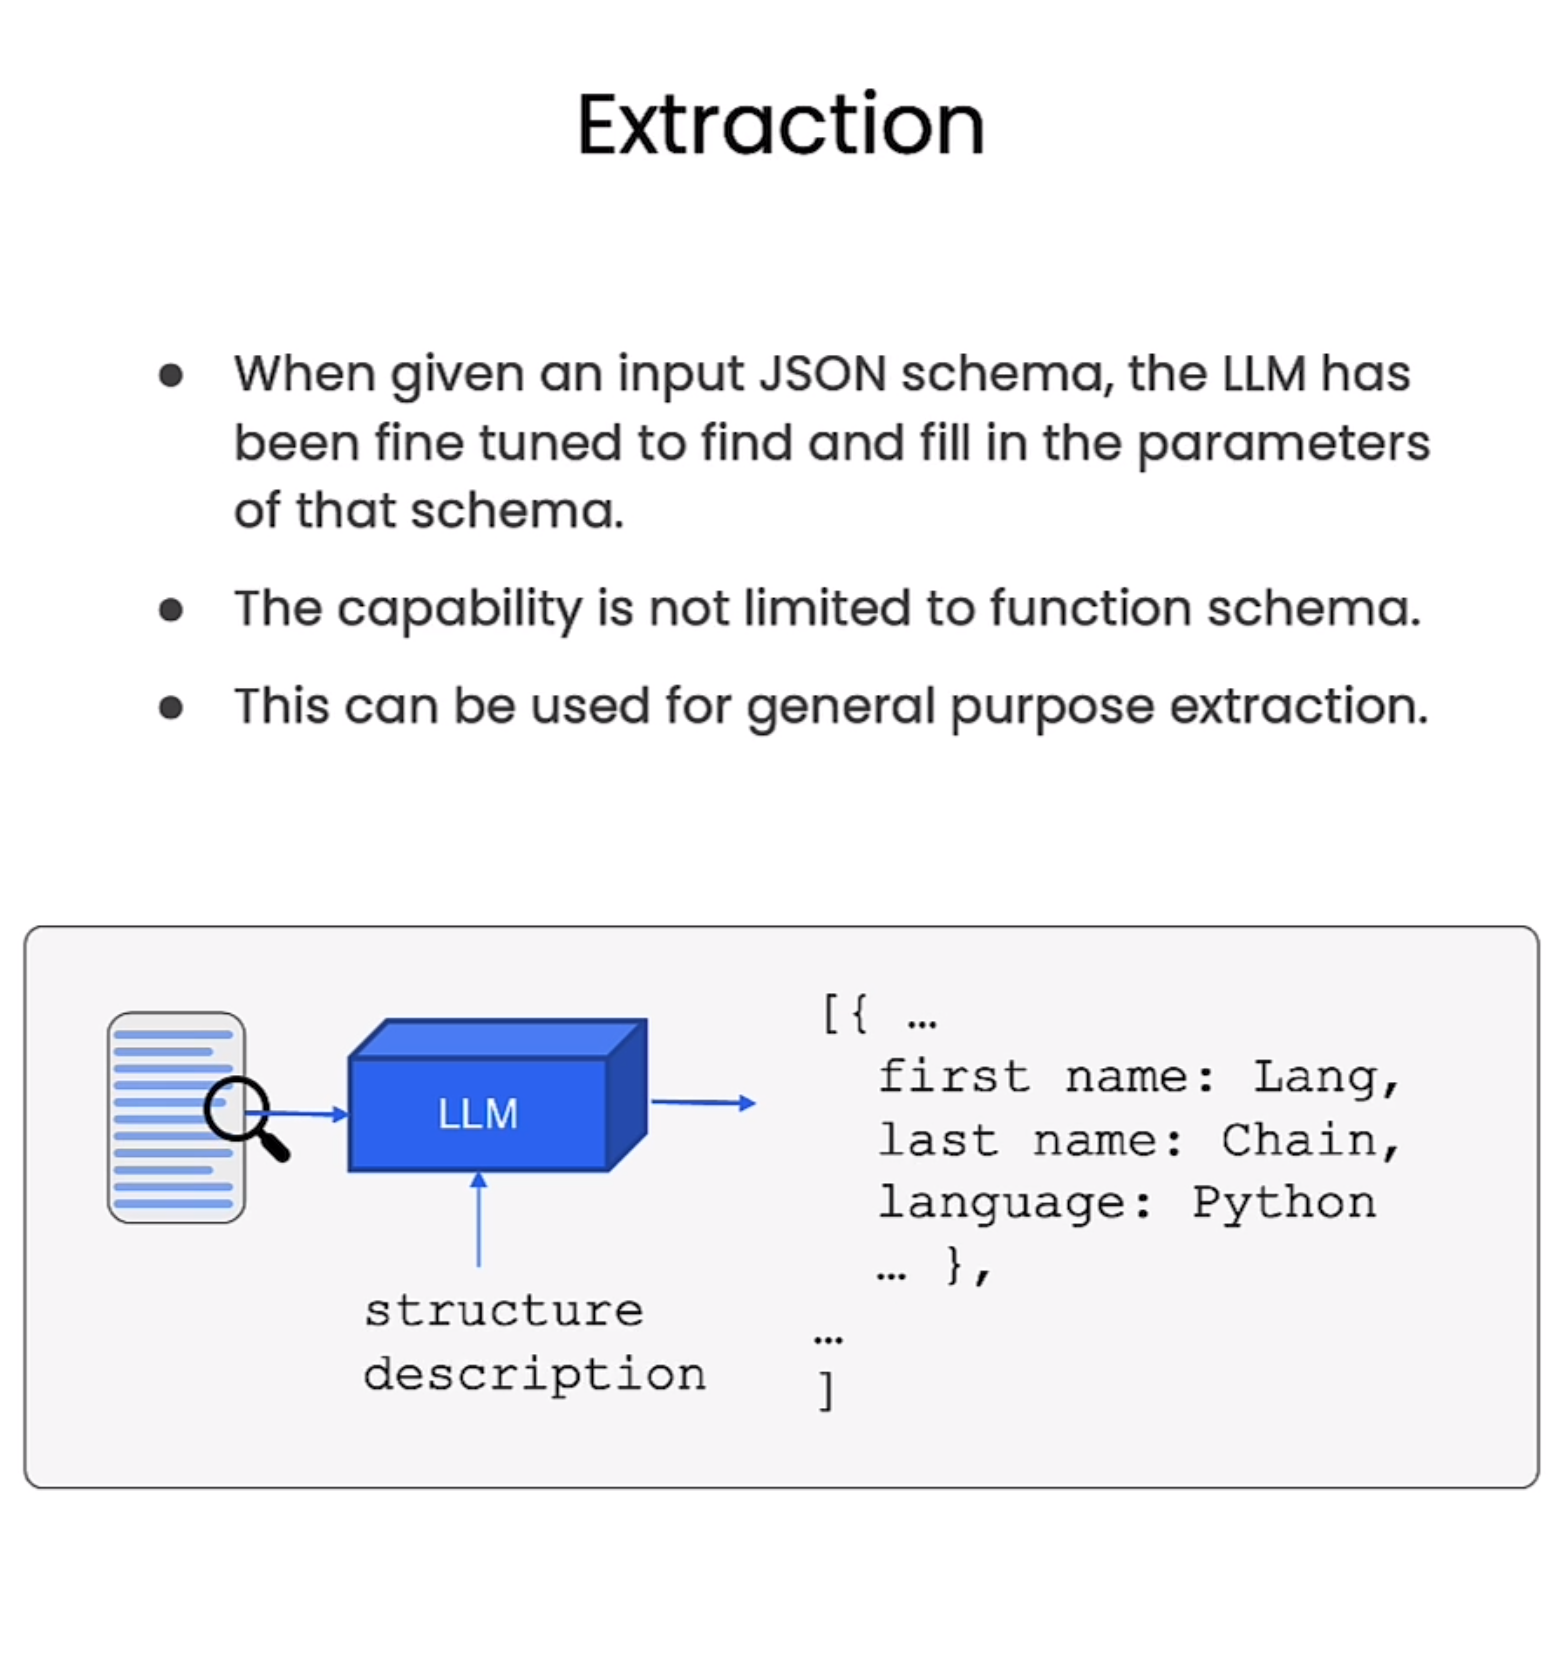

---

In [1]:
import os
import openai

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

In [2]:
from typing import List
from pydantic import BaseModel, Field
from langchain.utils.openai_functions import convert_pydantic_to_openai_function

In [3]:
class Tagging(BaseModel):
    """Tag the piece of text with particular info."""
    sentiment: str = Field(description="sentiment of text, should be `pos`, `neg`, or `neutral`")
    language: str = Field(description="language of text (should be ISO 639-1 code)")

In [4]:
convert_pydantic_to_openai_function(Tagging)

{'name': 'Tagging',
 'description': 'Tag the piece of text with particular info.',
 'parameters': {'title': 'Tagging',
  'description': 'Tag the piece of text with particular info.',
  'type': 'object',
  'properties': {'sentiment': {'title': 'Sentiment',
    'description': 'sentiment of text, should be `pos`, `neg`, or `neutral`',
    'type': 'string'},
   'language': {'title': 'Language',
    'description': 'language of text (should be ISO 639-1 code)',
    'type': 'string'}},
  'required': ['sentiment', 'language']}}

In [5]:
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI

In [6]:
model = ChatOpenAI(temperature=0)

In [7]:
tagging_functions = [convert_pydantic_to_openai_function(Tagging)]

In [8]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "Think carefully, and then tag the text as instructed"),
    ("user", "{input}")
])

In [9]:
model_with_functions = model.bind(
    functions=tagging_functions,
    function_call={"name": "Tagging"} # Forcing to use Tagging function
)

In [10]:
tagging_chain = prompt | model_with_functions

In [11]:
tagging_chain.invoke({"input": "I love langchain"})

AIMessage(content='', additional_kwargs={'function_call': {'name': 'Tagging', 'arguments': '{\n  "sentiment": "pos",\n  "language": "en"\n}'}})

In [12]:
tagging_chain.invoke({"input": "non mi piace questo cibo"})

AIMessage(content='', additional_kwargs={'function_call': {'name': 'Tagging', 'arguments': '{\n  "sentiment": "neg",\n  "language": "it"\n}'}})

In [13]:
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser

In [14]:
tagging_chain = prompt | model_with_functions | JsonOutputFunctionsParser()

Finally use an output parser to get a json Output

In [15]:
tagging_chain.invoke({"input": "non mi piace questo cibo"})

{'sentiment': 'neg', 'language': 'it'}

## Extraction

Extraction is similar to tagging, but used for extracting multiple pieces of information.

In [16]:
from typing import Optional
class Person(BaseModel):
    """Information about a person."""
    name: str = Field(description="person's name")
    age: Optional[int] = Field(description="person's age")

In [17]:
class Information(BaseModel):
    """Information to extract."""
    people: List[Person] = Field(description="List of info about people")

In [18]:
convert_pydantic_to_openai_function(Information)

{'name': 'Information',
 'description': 'Information to extract.',
 'parameters': {'title': 'Information',
  'description': 'Information to extract.',
  'type': 'object',
  'properties': {'people': {'title': 'People',
    'description': 'List of info about people',
    'type': 'array',
    'items': {'title': 'Person',
     'description': 'Information about a person.',
     'type': 'object',
     'properties': {'name': {'title': 'Name',
       'description': "person's name",
       'type': 'string'},
      'age': {'title': 'Age',
       'description': "person's age",
       'type': 'integer'}},
     'required': ['name']}}},
  'required': ['people']}}

In [19]:
extraction_functions = [convert_pydantic_to_openai_function(Information)]
extraction_model = model.bind(functions=extraction_functions, function_call={"name": "Information"})

In [20]:
extraction_model.invoke("Joe is 30, his mom is Martha")
# Martha's age is unknown and so set to 0, so add prompt in next steps to fix the issue 

AIMessage(content='', additional_kwargs={'function_call': {'name': 'Information', 'arguments': '{\n  "people": [\n    {\n      "name": "Joe",\n      "age": 30\n    },\n    {\n      "name": "Martha",\n      "age": 0\n    }\n  ]\n}'}})

In [21]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "Extract the relevant information, if not explicitly provided do not guess. Extract partial info"),
    ("human", "{input}")
])

In [22]:
extraction_chain = prompt | extraction_model

In [23]:
extraction_chain.invoke({"input": "Joe is 30, his mom is Martha"})
# Here Martha's age is not assumed to be 0

AIMessage(content='', additional_kwargs={'function_call': {'name': 'Information', 'arguments': '{\n  "people": [\n    {\n      "name": "Joe",\n      "age": 30\n    },\n    {\n      "name": "Martha"\n    }\n  ]\n}'}})

In [24]:
extraction_chain = prompt | extraction_model | JsonOutputFunctionsParser()

In [25]:
extraction_chain.invoke({"input": "Joe is 30, his mom is Martha"})

{'people': [{'name': 'Joe', 'age': 30}, {'name': 'Martha'}]}

In [26]:
from langchain.output_parsers.openai_functions import JsonKeyOutputFunctionsParser

In [27]:
extraction_chain = prompt | extraction_model | JsonKeyOutputFunctionsParser(key_name="people")

In [28]:
extraction_chain.invoke({"input": "Joe is 30, his mom is Martha"})

[{'name': 'Joe', 'age': 30}, {'name': 'Martha'}]

## Doing it for real

We can apply tagging to a larger body of text.

For example, let's load this blog post and extract tag information from a sub-set of the text.

In [29]:
from langchain.document_loaders import WebBaseLoader
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
documents = loader.load()

In [30]:
doc = documents[0]

In [31]:
page_content = doc.page_content[:10000] # First 10000 Characters

In [32]:
print(page_content[:1000])







LLM Powered Autonomous Agents | Lil'Log







































Lil'Log






















Posts




Archive




Search




Tags




FAQ




emojisearch.app









      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


 


Table of Contents



Agent System Overview

Component One: Planning

Task Decomposition

Self-Reflection


Component Two: Memory

Types of Memory

Maximum Inner Product Search (MIPS)


Component Three: Tool Use

Case Studies

Scientific Discovery Agent

Generative Agents Simulation

Proof-of-Concept Examples


Challenges

Citation

References





Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general

In [33]:
class Overview(BaseModel):
    """Overview of a section of text."""
    summary: str = Field(description="Provide a concise summary of the content.")
    language: str = Field(description="Provide the language that the content is written in.")
    keywords: str = Field(description="Provide keywords related to the content.")

In [34]:
overview_tagging_function = [
    convert_pydantic_to_openai_function(Overview)
]
tagging_model = model.bind(
    functions=overview_tagging_function,
    function_call={"name":"Overview"}
)
tagging_chain = prompt | tagging_model | JsonOutputFunctionsParser()

In [35]:
tagging_chain.invoke({"input": page_content})

{'summary': 'This article discusses the concept of building autonomous agents powered by LLM (large language model) as their core controller. It explores the key components of such agent systems, including planning, memory, and tool use. It also covers various techniques for task decomposition and self-reflection in autonomous agents. The article provides examples of case studies and challenges in implementing LLM-powered autonomous agents.',
 'language': 'English',
 'keywords': 'LLM, autonomous agents, planning, memory, tool use, task decomposition, self-reflection, case studies, challenges'}

In [36]:
class Paper(BaseModel):
    """Information about papers mentioned."""
    title: str
    author: Optional[str]


class Info(BaseModel):
    """Information to extract"""
    papers: List[Paper]

In [37]:
paper_extraction_function = [
    convert_pydantic_to_openai_function(Info)
]
extraction_model = model.bind(
    functions=paper_extraction_function, 
    function_call={"name":"Info"}
)
extraction_chain = prompt | extraction_model | JsonKeyOutputFunctionsParser(key_name="papers")

In [38]:
extraction_chain.invoke({"input": page_content})
# Extracts the whole article's title and authour instead of all the papers, so adding prompts in the next step.

[{'title': 'LLM Powered Autonomous Agents', 'author': 'Lilian Weng'}]

In [39]:
template = """A article will be passed to you. Extract from it all papers that are mentioned by this article. 

Do not extract the name of the article itself. If no papers are mentioned that's fine - you don't need to extract any! Just return an empty list.

Do not make up or guess ANY extra information. Only extract what exactly is in the text."""

prompt = ChatPromptTemplate.from_messages([
    ("system", template),
    ("human", "{input}")
])

In [40]:
extraction_chain = prompt | extraction_model | JsonKeyOutputFunctionsParser(key_name="papers")

In [41]:
extraction_chain.invoke({"input": page_content})

[{'title': 'Chain of thought (CoT; Wei et al. 2022)', 'author': 'Wei et al.'},
 {'title': 'Tree of Thoughts (Yao et al. 2023)', 'author': 'Yao et al.'},
 {'title': 'LLM+P (Liu et al. 2023)', 'author': 'Liu et al.'},
 {'title': 'ReAct (Yao et al. 2023)', 'author': 'Yao et al.'},
 {'title': 'Reflexion (Shinn & Labash 2023)', 'author': 'Shinn & Labash'},
 {'title': 'Chain of Hindsight (CoH; Liu et al. 2023)',
  'author': 'Liu et al.'},
 {'title': 'Algorithm Distillation (AD; Laskin et al. 2023)',
  'author': 'Laskin et al.'}]

In [42]:
extraction_chain.invoke({"input": "hi"})

[]

### Split the large article into smaller segments or 'splits' of manageable size, and then repeat a specific operation on each of these segments.


In [44]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_overlap=0)

In [45]:
splits = text_splitter.split_text(doc.page_content)

In [46]:
len(splits)

14

In [47]:
def flatten(matrix):
    flat_list = []
    for row in matrix:
        flat_list += row
    return flat_list

In [48]:
flatten([[1, 2], [3, 4]])

[1, 2, 3, 4]

In [49]:
print(splits[0])

LLM Powered Autonomous Agents | Lil'Log







































Lil'Log






















Posts




Archive




Search




Tags




FAQ




emojisearch.app









      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


 


Table of Contents



Agent System Overview

Component One: Planning

Task Decomposition

Self-Reflection


Component Two: Memory

Types of Memory

Maximum Inner Product Search (MIPS)


Component Three: Tool Use

Case Studies

Scientific Discovery Agent

Generative Agents Simulation

Proof-of-Concept Examples


Challenges

Citation

References





Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general probl

In [50]:
from langchain.schema.runnable import RunnableLambda

In [51]:
# For each element in the result of 'text_splitter.split_text(x)',
# create a dictionary with "input" key containing the 'doc'.
 
prep = RunnableLambda(
    lambda x: [{"input": doc} for doc in text_splitter.split_text(x)]
)

In [52]:
prep.invoke("hi")

[{'input': 'hi'}]

In [53]:
chain = prep | extraction_chain.map() | flatten

In [54]:
chain.invoke(doc.page_content)

[{'title': 'AutoGPT', 'author': ''},
 {'title': 'GPT-Engineer', 'author': ''},
 {'title': 'BabyAGI', 'author': ''},
 {'title': 'Chain of thought (CoT; Wei et al. 2022)', 'author': ''},
 {'title': 'Tree of Thoughts (Yao et al. 2023)', 'author': ''},
 {'title': 'LLM+P (Liu et al. 2023)', 'author': ''},
 {'title': 'ReAct (Yao et al. 2023)', 'author': ''},
 {'title': 'Reflexion (Shinn & Labash 2023)', 'author': ''},
 {'title': 'Reflexion framework', 'author': 'Shinn & Labash'},
 {'title': 'Chain of Hindsight', 'author': 'Liu et al.'},
 {'title': 'Algorithm Distillation', 'author': 'Laskin et al.'},
 {'title': 'Algorithm Distillation', 'author': 'Laskin et al. 2023'},
 {'title': 'ED (expert distillation)', 'author': ''},
 {'title': 'RL^2', 'author': 'Duan et al. 2017'},
 {'title': 'LSH: Locality-Sensitive Hashing', 'author': ''},
 {'title': 'ANNOY: Approximate Nearest Neighbors Oh Yeah', 'author': ''},
 {'title': 'HNSW: Hierarchical Navigable Small World', 'author': ''},
 {'title': 'FAISS: 